In [1]:
import pandas as pd
import string
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from spacy.lang.it import Italian

from sklearn import metrics
from sklearn import svm

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacymoji import Emoji

from nltk.stem.snowball import SnowballStemmer
import simplemma

nltk.download('stopwords')
nltk.download('punkt')

punctuations = string.punctuation

stop_words = set(stopwords.words('italian'))

parser = Italian()
punctuations = string.punctuation

stemmer = SnowballStemmer('italian')

c:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vito\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vito\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
! pip install simplemma


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# function to evaluate the classifer on the test set

def evaluating_results(X_test, y_test, classifier):
    predicted = classifier.predict(X_test)
    predicted = [int(x) for x in predicted]

    acc = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average='macro')
    recall = metrics.recall_score(y_test, predicted, average='macro')
    fm = metrics.f1_score(y_test, predicted, average='macro')
    print("Results:")
    print(" Acc = {0} \n P = {1} \n R = {2} \n F1 = {3}".format(acc, precision, recall, fm, average='macro'))
    print("======================================================")
    print(metrics.classification_report(y_test, predicted, digits=2))

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, predicted)

    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot()

This function performs the preprocessing task. It's used inside the TfIdfVectorizer function.

In [4]:
def preprocessing_text(sentence):

    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]
    mytokens = [ word.lower() for word in mytokens]

    # remove URL \ url
    mytokens = [re.sub(r"URL|url", "", token) for token in mytokens]

    # remove @user
    mytokens = [re.sub(r'@\w+\s*', "", token) for token in mytokens]

    # remove words with numbers
    mytokens = [re.sub(r'\b\w*\d\w*\b', "", token) for token in mytokens]
    mytokens = [re.sub(r"\.{2,4}", "", token) for token in mytokens]
    
    # remove extra whitespaces
    mytokens = [re.sub(r"\s+", "", token) for token in mytokens]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    mytokens = [simplemma.lemmatize(token, lang='it') for token in mytokens]
    mytokens = [stemmer.stem(token) for token in mytokens]
    return mytokens


In [5]:
# training set

d = pd.read_csv('./trainingset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
d = d.drop(0)   # drop the first row with column's names

task_label = "hs"  # change this to change the task [tasks: hs / st]

X_train = d['text']     
y_train = d[task_label]
print(d.info)

# test set - tweets
t = pd.read_csv('./testset_tweet.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')
X_test = t['text'] 
y_test = t[task_label] 

# test set - news
t_news = pd.read_csv('./testset_news.tsv', sep='\t', names=["id", "text", "hs", "st"], encoding='utf-8')

X_test_news = t_news['text'] 
y_test_news = t_news[task_label] 

vector = TfidfVectorizer(tokenizer = preprocessing_text, lowercase = True)

<bound method DataFrame.info of         id                                               text hs st
1     2066  È terrorismo anche questo, per mettere in uno ...  0  0
2     2045  @user @user infatti finché ci hanno guadagnato...  0  0
3       61  Corriere: Tangenti, Mafia Capitale dimenticata...  0  0
4     1259  @user ad uno ad uno, perché quando i migranti ...  0  0
5      949  Il divertimento del giorno? Trovare i patrioti...  0  0
...    ...                                                ... .. ..
6833  9340  Gli stati nazionali devono essere pronti a rin...  0  0
6834  9121  Il ministro dell'interno della Germania #Horst...  0  0
6835  8549  #Salvini: In Italia troppi si sono montati la ...  0  0
6836  9240  @user @user Chi giubila in buona fede non ha c...  0  0
6837  8000  I giovani cristiani in #Etiopia sono indotti d...  0  1

[6837 rows x 4 columns]>


In [6]:
X_train = vector.fit_transform(X_train)
X_test = vector.transform(X_test)
X_test_news = vector.transform(X_test_news)

Undersampling of the dataset with the near miss algorithm

In [7]:
# Undersample of the dataset with NearMiss

from collections import Counter
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot

undersample = NearMiss(version=3, n_neighbors=7)
X_undersampled, y_undersampled = undersample.fit_resample(X_train, y_train)

print(Counter(y_undersampled))

Counter({'1': 2766, '0': 2454})


c:\Users\Vito\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Oversampling of the dataset with the SMOTE algorithm

In [8]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_smote, y_smote = sm.fit_resample(X_train, y_train.ravel())
y_smote = [int(x) for x in y_smote]

Counter(y_smote)

Counter({0: 4071, 1: 4071})

In [9]:
classifier = svm.LinearSVC()

Traning on the original dataset

Results:
 Acc = 0.7387173396674585 
 P = 0.7387508588566298 
 R = 0.7388011597634323 
 F1 = 0.738709313405888
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       641
           1       0.73      0.74      0.74       622

    accuracy                           0.74      1263
   macro avg       0.74      0.74      0.74      1263
weighted avg       0.74      0.74      0.74      1263



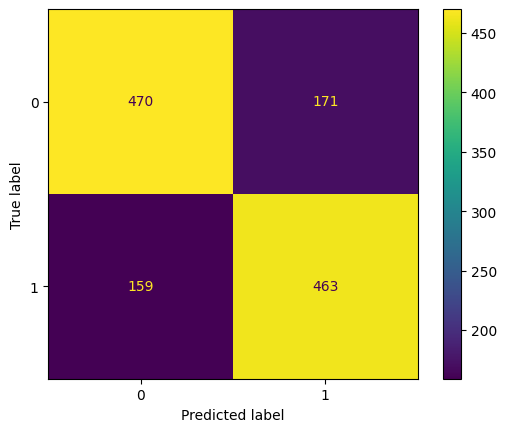

In [10]:
classifier.fit(X_train, y_train)
evaluating_results(X_test, y_test, classifier)

Results:
 Acc = 0.726 
 P = 0.7154823269513991 
 R = 0.6621780772095118 
 F1 = 0.6693233438409663
              precision    recall  f1-score   support

           0       0.73      0.89      0.81       319
           1       0.70      0.43      0.53       181

    accuracy                           0.73       500
   macro avg       0.72      0.66      0.67       500
weighted avg       0.72      0.73      0.71       500



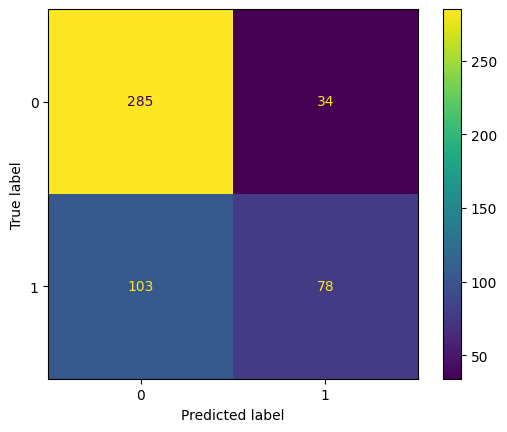

In [11]:
evaluating_results(X_test_news, y_test_news, classifier)

Traning on the undersampled dataset

UNDERSAMPLED DATASET
Results:
 Acc = 0.7094220110847189 
 P = 0.7172584423038144 
 R = 0.710773961505084 
 F1 = 0.7075889069241198
              precision    recall  f1-score   support

           0       0.76      0.62      0.68       641
           1       0.67      0.80      0.73       622

    accuracy                           0.71      1263
   macro avg       0.72      0.71      0.71      1263
weighted avg       0.72      0.71      0.71      1263



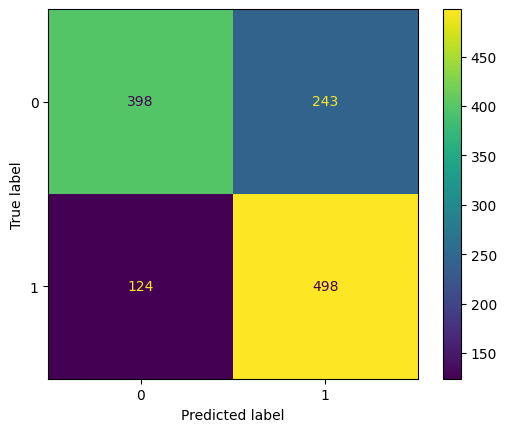

In [12]:
classifier.fit(X_undersampled, y_undersampled)

print("UNDERSAMPLED DATASET")
evaluating_results(X_test, y_test, classifier)

Results:
 Acc = 0.726 
 P = 0.7029314616019818 
 R = 0.6872737664317012 
 F1 = 0.692514869262709
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       319
           1       0.64      0.55      0.59       181

    accuracy                           0.73       500
   macro avg       0.70      0.69      0.69       500
weighted avg       0.72      0.73      0.72       500



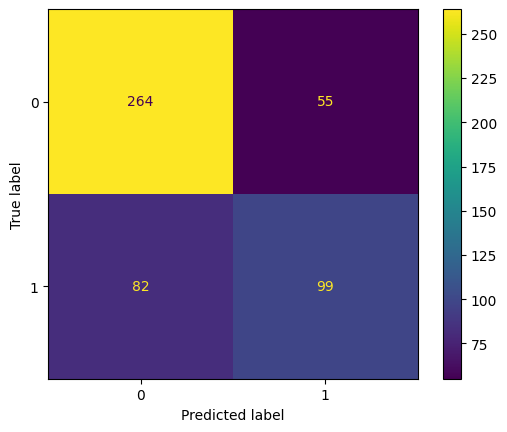

In [13]:
evaluating_results(X_test_news, y_test_news, classifier)

Training on the oversampled dataset

OVERSAMPLED DATASET
Results:
 Acc = 0.733174980205859 
 P = 0.7345631771861281 
 R = 0.7336983511494801 
 F1 = 0.7330243515993851
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       641
           1       0.71      0.77      0.74       622

    accuracy                           0.73      1263
   macro avg       0.73      0.73      0.73      1263
weighted avg       0.73      0.73      0.73      1263



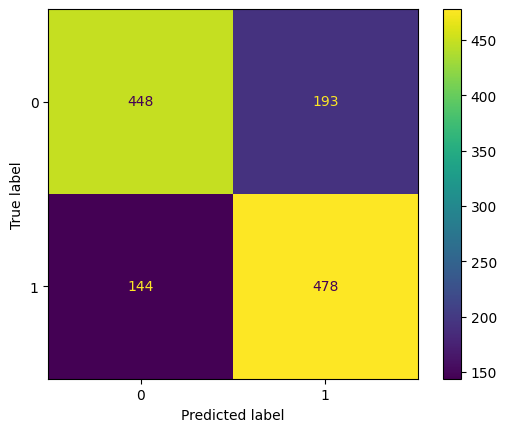

In [14]:
classifier.fit(X_smote, y_smote)

print("OVERSAMPLED DATASET")
evaluating_results(X_test, y_test, classifier)

Results:
 Acc = 0.73 
 P = 0.7142644936762583 
 R = 0.6748731360085904 
 F1 = 0.6827276957570118
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       319
           1       0.68      0.48      0.56       181

    accuracy                           0.73       500
   macro avg       0.71      0.67      0.68       500
weighted avg       0.72      0.73      0.72       500



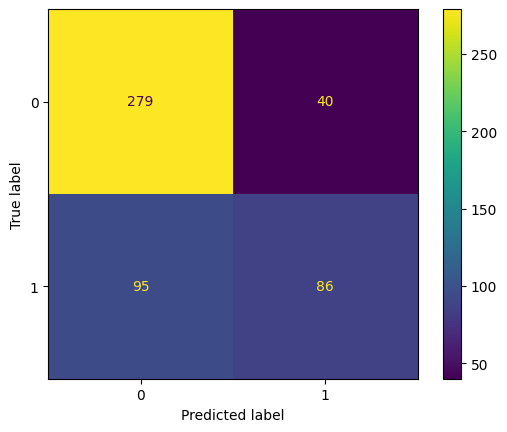

In [15]:
evaluating_results(X_test_news, y_test_news, classifier)